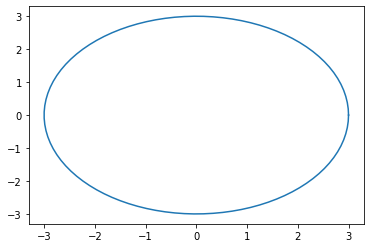

28.255356206999483
28.255356206999483


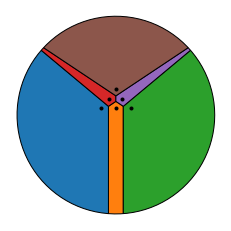

[1. 1. 1. 1. 1. 1.]


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import nlopt

import time

optim_try  =0

from shapely import geometry
from scipy.spatial import ConvexHull
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial.distance import cdist
from shapely.geometry import LineString, MultiPoint, Polygon, Point
from shapely.geometry.polygon import LinearRing
from shapely.ops import shared_paths
from shapely.ops import polygonize

import scipy as scipy
from scipy.optimize import minimize


outer_poly = np.array([[-1,-1],[0,-2],
                       [2,-1],
                       [2,3],
                       [-1,4],[-2,2]]
                       )

thetas = np.linspace(0,2*np.pi,100)

xx = 3*np.cos(thetas)
yy = 3*np.sin(thetas)



c = np.zeros((len(xx),2))
c[:,0] = xx
c[:,1] = yy

outer_poly= c

#outer_poly = np.array([[-3,-3],[3,-3],
#                       [3,3],
#                       [-3,3]]
#                       )
xx = outer_poly[:,0]
yy = outer_poly[:,1]


minx = np.amin(xx)
maxx = np.amax(xx)
miny = np.amin(yy)
maxy = np.amax(yy)


plt.figure()
plt.plot(outer_poly[:,0],outer_poly[:,1])
plt.show()

oP = Polygon(outer_poly)
totarea = oP.area;

print(totarea)

coords= np.array([[0,0],
                  [0,1],
                  [1,1],
                  [1,-0.3],
                  [0.5,0.3],
                  [1.5,2],
                   [-0.5,2.5],
                  [-0.2,2.2],
                  [0.2,2.2],
                  [-0.2,-1.2],
                  [-1.2,1.2]])


def random_points_within(poly, num_points):
    min_x, min_y, max_x, max_y = poly.bounds

    points = []

    while len(points) < num_points:
        v = [random.uniform(min_x, max_x), random.uniform(min_y, max_y)]
        random_point = Point(v)
        if (random_point.within(poly)):
            points.append(v)

    return np.array(points)

#coords = random_points_within(Polygon(outer_poly),6) 
meanarea = totarea/len(coords)


def extract_poly(vor,fact=1,debug=0):
    pts = vor.points  # get the points, each one has a region
    center = MultiPoint(vor.points).convex_hull.centroid
    center = np.array([center.x,center.y])
    vert = vor.vertices
    #print(vert)
    ridge_points = vor.ridge_points
    ridge_vertices = vor.ridge_vertices
    #print(ridge_points)
    #print(ridge_vertices)
    inf_ridges = np.zeros(len(ridge_vertices))
    for i in range(0,len(ridge_vertices)):
        inf_ridges[i]=sum(np.array(ridge_vertices[i])==-1)
    ListPoly = []
    
    boundary = np.zeros(len(pts))
    
    # build ridges first, then construct polygon... simpler
    #plt.figure()
    ridge_pts = []
    for i in range(0,len(ridge_points)):
        ridge = ridge_points[i]
        vridge = ridge_vertices[i]
        #print(ridge_vertices[i])
        inf_ridge = (-1 in ridge_vertices[i])
        if inf_ridge:
            for j in ridge_vertices[i]:
                if j!=-1:
                    pt2 = vert[j,:]
            i1 = ridge[0]
            i2 = ridge[1]
            # ridge 1   points i and q[0]
            v = pts[i1]-pts[i2]
            n = np.array([-v[1],v[0]])     # normal vector
            n = n/np.sqrt(np.sum(n**2))
            mid = (pts[i1,:]+pts[i2,:])/2
            cvec = mid-center
            if(np.dot(cvec,n)<0):
                n = -n
            pt1 = mid+fact*n
            #print(ridge)
            #plt.plot(pt1[0],pt1[1],'rx')
            #plt.plot(pt2[0],pt2[1],'bx')
            ridge_pts.append(np.array([pt2,pt1]))
        else:
            pt1 = vert[vridge[0],:]
            pt2 = vert[vridge[1],:]
            ridge_pts.append(np.array([pt1,pt2]))

            #print(pt1)
            #plt.plot(pt1[0],pt1[1],'gx')
            #plt.plot(pt2[0],pt2[1],'gx')
    #plt.show()       
    #print(ridge_pts)
    
    for i in range(0,len(pts)):
        reg = vor.regions[vor.point_region[i]]
        if -1 not in reg:
            ListPoly.append(vert[reg])
        else:
            #print("Infinite region:")
            #print(reg)
            # find ridges near the point p
            boundary[i]=1
            pt = pts[i]
            tS = [sum(a==i) for a in ridge_points]  # find point indexes for ridges near p
            tS = tS*inf_ridges                      # hold only infinite ridges
            qq = np.where(tS==1)                     # find ridge points indexes
            qq = qq[0]
            #print("Ridge points")
            q = []
            for j in qq:
                for k in range(0,2):
                    if ridge_points[j][k]!=i:
                        q.append(ridge_points[j][k])
                        

            # ridge 1   points i and q[0]
            
            act_pts = ridge_pts[qq[0]]
            
            pt1 = act_pts[1,:]
            
            
            
            # ridge 2   points i and q[1]
            act_pts = ridge_pts[qq[1]]
            
            pt2 = act_pts[1,:]
            
            poly = np.zeros((len(reg)+1,2))
            pos = 0
            for j in range(0,len(reg)):
                if reg[j]>=0:
                    poly[pos] = vert[reg[j]]
                    pos = pos+1
                else:
                    poly[pos] = pt2
                    pos = pos+1
                    poly[pos] = pt1
                    pos = pos+1
            if debug==1:
                plt.figure()
                print(poly)
                plt.plot(pts[:,0],pts[:,1],'rx')
                plt.plot(vert[:,0],vert[:,1],'b.')
                tpoly = np.vstack((poly,poly[0,:]))
                plt.plot(tpoly[:,0],tpoly[:,1])
                plt.show()
            
            c = poly.mean(axis=0)
            angles = np.arctan2(poly[:,1] - c[1], poly[:,0] - c[0])
            #print(np.argsort(angles))
            newpoly = poly[np.argsort(angles),:]    
            ListPoly.append(poly)            
    return ListPoly, boundary, ridge_pts



def PolyVoronoi(coords,poly,fact=10,plotting=0,debug=0,save_string=None):
    vor = Voronoi(coords)                 # voronoi diag
    
    # search for outer points and set them to -1??
    
    
    ListPoly,bnd,ridge_pts = extract_poly(vor,fact=fact,debug=debug)  # extract polygons
    oP = Polygon(poly)
    
    bnd = np.zeros(len(coords))
    poly_shapes = []
    pos = 0
    for p in  ListPoly:
        zz = ConvexHull(p);
        qz = zz.points[zz.vertices]
        qp = Polygon(qz)
        qpint =qp.intersection(oP)
        #print(qp)
        poly_shapes.append(qpint)
        #print(pos," ",qp.area," ",qpint.area)
        if qp.area>qpint.area:
            bnd[pos]=1
        pos = pos+1
        
    if plotting==1:
        plt.figure()
    Areas = np.zeros(len(poly_shapes))
    for i in range(0,len(poly_shapes)):
        if plotting==1:
            plt.plot(coords[i,0],coords[i,1],color='black', marker='.')
        if poly_shapes[i].is_empty == 0:
            if plotting==1:
                x,y = poly_shapes[i].exterior.xy
                plt.fill(x,y,edgecolor='black')
            Areas[i] = poly_shapes[i].area;
    if plotting==1:
        plt.axis("scaled")
        plt.axis('off')
        if save_string!=None:
            plt.savefig(save_string+'.pdf',bbox_inches='tight',pad_inches = -0.1)
        plt.show()
        

    return poly_shapes, bnd, Areas, vor, ridge_pts  




#outer_poly = np.array([[-1,0],[1,0],[0,np.sqrt(3)]])






oP = Polygon(outer_poly)
totarea = oP.area;

print(totarea)

coords= np.array([[-0.45,0.2],[0,0.2],[0.45,0.2],[-0.2,0.5],[0.2,0.5],[0,0.8]])

ps, bnd, areas, vor, ridge_pts = PolyVoronoi(coords,outer_poly,fact=10,plotting=1,save_string="test")


print(bnd)

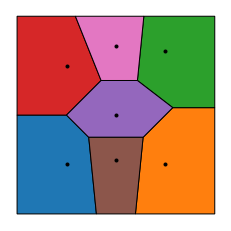

Grad perim cell  1
8.72986722244562e-07
Grad perim cell  2
8.765394359233625e-07
Grad perim cell  3
7.278839702085094e-07
Grad perim cell  4
5.562006401005348e-07
Grad perim cell  5
1.107612981054995e-06
Grad perim cell  6
1.3713474800516878e-06
Grad perim cell  7
1.095171393628025e-06


In [2]:
def AreaVoronoi(coords,poly):
    coords = np.reshape(coords,(-1,2))
    ps, bnd, areas, vor, ridge_pts = PolyVoronoi(coords,poly,debug=0,fact=10)
    perims = np.zeros(len(ps))
    for i in range(0,len(ps)):
        if ps[i].is_empty == 0:
            x,y = ps[i].exterior.xy
            perims[i] = np.sum(np.sqrt((x-np.roll(x,1))**2+(y-np.roll(y,1))**2))
        else:
            perims[i] = 10**3
            areas[i]  = 10**3
            
    return areas

def PerimVoronoi(coords,poly,plotting=0,save_string=None):
    coords = np.reshape(coords,(-1,2))
    ps, bnd, areas, vor, ridge_pts = PolyVoronoi(coords,poly,debug=0,fact=100,plotting=plotting,save_string=save_string)
    perims = np.zeros(len(ps))
    for i in range(0,len(ps)):
        if ps[i].is_empty == 0:
            x,y = ps[i].exterior.xy
            perims[i] = np.sum(np.sqrt((x-np.roll(x,1))**2+(y-np.roll(y,1))**2))
        else:
            perims[i] = 10**3
            areas[i]  = 10**3
            
    return perims

def AreaFuncGrad(coords,poly):
    coords = np.reshape(coords,(-1,2))
    ps, bnd, areas, vor, ridge_vert = PolyVoronoi(coords,poly,debug=0,fact=100)
    
    area = np.sum(areas)
    grad = np.zeros((2*len(coords),len(coords)))
    
    ngrad = np.zeros((2*len(coords),len(coords)))
    tgrad = np.zeros((2*len(coords),len(coords)))

    
    #plt.figure()
    e1 = np.array([1,0])
    e2 = np.array([0,1])
    # for any ridge get the corresponding side and projection
    for i in range(0,len(vor.ridge_points)):
        vridge = ridge_vert[i]
        ridge = vor.ridge_points[i]
        
        i1 = ridge[0]
        i2 = ridge[1]
        point1 = coords[i1,:]
        point2 = coords[i2,:]
        seg = point2-point1
        lseg = np.linalg.norm(seg)
        normal = (seg)/np.linalg.norm(seg) # normal pointing from cell 1 towards cell 2
        
        #print(ridge)
        pridge = LineString([vridge[0,:],vridge[1,:]])
        common = pridge.intersection(poly)       # common edge
        #print(common)
        #print(common)
        if common.is_empty==0:
            ccoords = np.array(common.coords)
            #print(ccoords)
            #plt.plot(ccoords[:,0],ccoords[:,1])
            mid = (point1+point2)/2
        
            vseg = ccoords[1,:]-ccoords[0,:]
        
            orvec = np.dot(np.append(seg,0),np.append(vseg,0))
            orient = 1#np.sign(orvec)
            #print("Orient=",orient)
        
            len1 = np.linalg.norm(mid-ccoords[0,:])
            len2 = np.linalg.norm(mid-ccoords[1,:])
            length = np.linalg.norm(vseg)
            #print("Length=",length)
            # normal part 
            nv = np.dot(e1,normal)/2*length
            ngrad[2*i1,i1] = ngrad[2*i1,i1]+nv     # cell i1
            ngrad[2*i2,i1] = ngrad[2*i2,i1]+nv    

            ngrad[2*i1,i2] = ngrad[2*i1,i2]-nv     # cell i2
            ngrad[2*i2,i2] = ngrad[2*i2,i2]-nv            

            nv = np.dot(e2,normal)/2*length
            ngrad[2*i1+1,i1] = ngrad[2*i1+1,i1]+nv     # cell i1
            ngrad[2*i2+1,i1] = ngrad[2*i2+1,i1]+nv    

            ngrad[2*i1+1,i2] = ngrad[2*i1+1,i2]-nv     # cell i2
            ngrad[2*i2+1,i2] = ngrad[2*i2+1,i2]-nv    

            # tangential part

            tv = orient*np.dot(e1,vseg)/2/lseg/length*(len2**2-len1**2)
            tgrad[2*i1,i1] = tgrad[2*i1,i1]+tv     # cell i1
            tgrad[2*i2,i1] = tgrad[2*i2,i1]-tv      

            tgrad[2*i1,i2] = tgrad[2*i1,i2]-tv     # cell i2
            tgrad[2*i2,i2] = tgrad[2*i2,i2]+tv      


            tv = orient*np.dot(e2,vseg)/2/lseg/length*(len2**2-len1**2)
            tgrad[2*i1+1,i1] = tgrad[2*i1+1,i1]+tv     # cell i1
            tgrad[2*i2+1,i1] = tgrad[2*i2+1,i1]-tv    

            tgrad[2*i1+1,i2] = tgrad[2*i1+1,i2]-tv     # cell i2
            tgrad[2*i2+1,i2] = tgrad[2*i2+1,i2]+tv    

            #print(ccoords)
    #plt.show()
    grad = tgrad+ngrad
    return areas, grad

def PerimFDGrad(coords,poly):
    n = len(coords)
    a0 = PerimVoronoi(coords,poly)
    eps = 1e-6
    grad = np.zeros((2*len(coords),n))
    for i in range(0,n):
        d = np.zeros(coords.shape)
        d[i,0] = 1
        cc = coords+eps*d
        ap = PerimVoronoi(cc,poly)
        grad[2*i,:]=(ap-a0)/eps
        d = np.zeros(coords.shape)
        d[i,1] = 1
        cc = coords+eps*d
        ap = PerimVoronoi(cc,poly)
        grad[2*i+1,:]=(ap-a0)/eps
    return grad

import warnings
warnings.filterwarnings('error')

def CircumcenterDer(coords,DirA):
    
    A = coords[0,:]
    B = coords[1,:]
    C = coords[2,:]
    
    D = 2*(A[0]*(B[1]-C[1])+B[0]*(C[1]-A[1])+C[0]*(A[1]-B[1]))
    
    Nx = (np.sum(A**2)*(B[1]-C[1])+np.sum(B**2)*(C[1]-A[1])+np.sum(C**2)*(A[1]-B[1]))
    Ny = -(np.sum(A**2)*(B[0]-C[0])+np.sum(B**2)*(C[0]-A[0])+np.sum(C**2)*(A[0]-B[0]))
    
    Ox = 1/D*Nx
    Oy = 1/D*Ny
    
    
    Dx = 2*(B[1]-C[1])
    Dy = 2*(C[0]-B[0])
    
    Oxx = -Dx/D**2*Nx+1/D*2*A[0]*(B[1]-C[1])
    Oxy = -Dy/D**2*Nx+1/D*(2*A[1]*(B[1]-C[1])-np.sum(B**2)+np.sum(C**2))
    
    Derx = np.dot([Oxx,Oxy],DirA)
    
    Oyx = -Dx/D**2*Ny+1/D*(2*A[0]*(C[0]-B[0])+np.sum(B**2)-np.sum(C**2))
    Oyy = -Dy/D**2*Ny+1/D*2*A[1]*(C[0]-B[0])
    
    Dery = np.dot([Oyx,Oyy],DirA)
    
    Center = np.array([Ox,Oy])
    return Center, np.array([Derx,Dery])



def PerimFuncGrad(coords,poly,plotting=0):
    from numpy.linalg import norm
    coords = np.reshape(coords,(-1,2))
    ps, bnd, areas, vor, ridge_vert = PolyVoronoi(coords,poly,debug=0,fact=100,plotting=plotting)
    
    #print(ridge_vert)
    
    perims = np.zeros(len(ps))
    for i in range(0,len(ps)):
        if ps[i].is_empty == 0:
            x,y = ps[i].exterior.xy
            perims[i] = np.sum(np.sqrt((x-np.roll(x,1))**2+(y-np.roll(y,1))**2))
    
    area = np.sum(areas)
    grad = np.zeros((2*len(coords),len(coords)))
    
    ngrad = np.zeros((2*len(coords),len(coords)))
    tgrad = np.zeros((2*len(coords),len(coords)))
    
    e1 = np.array([1,0])
    e2 = np.array([0,1])
    
    #print("Perims: ",perims)
    
    vertices = vor.vertices
    ridge_vertices = vor.ridge_vertices
    ridge_pts = vor.ridge_points
    #print(vertices)
    Poly = Polygon(poly)
    
    #print(ridge_vertices)
    #print(ridge_pts)
    # construct list of ridges with given vertex
    
    
    for i in range(0,len(vertices)):
        # test if current vertex is inside the polygon!
        vert = vertices[i]   # store current vertex
        if Poly.contains(Point(vertices[i,:])):
            #print("Inside")
            vL = []
            # find index of ridges containing vertex i
            # need indices to be able to find the points easily (they have the same order)
            for ind in range(0,len(ridge_vertices)):
                if i in ridge_vertices[ind]:
                    vL.append(ind)
            #print("Ridges containing vertex[",i,"]: ",vL)
            
            # point list
            pL = []
            closePts = np.unique(ridge_pts[vL,:])
            for j in range(0,len(closePts)):
                p0 = closePts[j]
                restr_ridge_pts = ridge_pts[vL,:]
                #print(p0," and ",restr_ridge_pts)
                tS = np.sum(restr_ridge_pts==p0,axis=1)
                qq = np.nonzero(tS==1)[0]
                #print("tS=",qq)
                tri = [p0]
                for k in qq:
                    if restr_ridge_pts[k,0] != p0:
                        tri.append(restr_ridge_pts[k,0])
                    else:
                        tri.append(restr_ridge_pts[k,1])
                # now tri contains the three points wiht vertex p0 on first position!
                # compute sensitivity of voronoi vertex (circumcenter) w.r.t. perturbation in p0
                
                tri_coords = coords[tri,:]
                unused, Der1 = CircumcenterDer(tri_coords,e1)
                unused, Der2 = CircumcenterDer(tri_coords,e2)
                                
                # for each ridge in triangle
                # project Der on it and add the gradient contribution to the grad of two cells 
                
                # loop on ridges coming to current vertex
                #plt.figure()
                for k in range(0,len(vL)):
                    # need vector of the rdige ENDING in vertices[i]!
                    
                    if 1==1:
                    
                        vert = vertices[i] # current vertex
                        rVert = ridge_vert[vL[k]] # ridge vertices (possibly longer)
                        rPoint = ridge_pts[vL[k]] # to see which cells are affected

                        #print("Ridge vertices vL[k] ",ridge_vertices[vL[k]])
                        #print(rVert)

                        act_ridge = ridge_vertices[vL[k]]
                        if -1 not in act_ridge:
                            if act_ridge[0]!=i: #if first vertex of ridge is not i
                                other = rVert[0,:]
                            else:
                                other = rVert[1,:]
                        else:
                            other = rVert[1,:]
                        ridgeVect = vert-other
                        ridgeVect = ridgeVect/norm(ridgeVect)

                        # compute gradient for current ridge
                        gx = np.dot(ridgeVect,Der1)
                        gy = np.dot(ridgeVect,Der2)

                        # add contribution
                        grad[2*p0,rPoint[0]]=grad[2*p0,rPoint[0]]+gx
                        grad[2*p0,rPoint[1]]=grad[2*p0,rPoint[1]]+gx

                        grad[2*p0+1,rPoint[0]]=grad[2*p0+1,rPoint[0]]+gy
                        grad[2*p0+1,rPoint[1]]=grad[2*p0+1,rPoint[1]]+gy

                        #rPlot = np.vstack((vert,other))
                        #plt.plot(rPlot[:,0],rPlot[:,1])
                
                #plt.show()
        
            #print("Outside: nothing to do")
        
        # loop on ridges and find if they intersect the outer polygon
    
    
    
    circpoly = np.vstack((poly,poly[0,:]))
    lPoly = LineString(circpoly)
    
    #print(lPoly)
    
    for i in range(0,len(ridge_vertices)):
        #print(ridge_vertices[i])
        #print(ridge_vert[i])
        ridge_line = LineString((a[0],a[1]) for a in ridge_vert[i])
        geom = ridge_line.intersection(lPoly)
        rPoint = ridge_pts[i]
        if geom.is_empty==0:
            #plt.plot(ridge_vert[i][:,0],ridge_vert[i][:,1])
            #print(geom)
            
            # find segment
            for j in range(0,len(circpoly)-1):
                A = circpoly[j,:]
                B = circpoly[j+1,:]
                actLine = LineString([(A[0],A[1]),(B[0],B[1])])
                if actLine.contains(geom):
                    break
            
            
            act = ridge_pts[i]
            i1 = act[0]
            i2 = act[1]
            
            p1 = coords[i1,:]
            p2 = coords[i2,:]
            
            orient = np.sign(np.dot(p1-p2,A-B))
            lengthAB = norm(A-B)
            ABvec = orient*(A-B)/lengthAB
            
            # moving p1, reflect p2 w.r.t. AB
            proj = B+(A-B)*np.dot(A-B,p2-B)/lengthAB**2
            refl = 2*proj-p2
            
            tri_coords = np.vstack((p1,p2,refl))
                    
            # perturb vertex p1
            unused, Der1 = CircumcenterDer(tri_coords,e1)
            unused, Der2 = CircumcenterDer(tri_coords,e2)
            
            # compute contributions
            ridgeVect = ridge_vert[i][1,:]-ridge_vert[i][0,:]
            ridgeVect = ridgeVect/norm(ridgeVect)
            ridgeVect = np.sign(np.dot(ridgeVect,refl-p2))*ridgeVect
            
            # add contribution for ridge
            
            gx = np.dot(ridgeVect,Der1)
            gy = np.dot(ridgeVect,Der2)
            
            
            
            ABvec = -ABvec
            # add tangential contribution
            tx = np.dot(ABvec,Der1)
            ty = np.dot(ABvec,Der2)
            
            grad[2*i1,rPoint[0]]=grad[2*i1,rPoint[0]]+gx+tx
            grad[2*i1,rPoint[1]]=grad[2*i1,rPoint[1]]+gx-tx

            grad[2*i1+1,rPoint[0]]=grad[2*i1+1,rPoint[0]]+gy+ty
            grad[2*i1+1,rPoint[1]]=grad[2*i1+1,rPoint[1]]+gy-ty
            
            
            # reflect p1
            proj = B+(A-B)*np.dot(A-B,p1-B)/lengthAB**2
            refl = 2*proj-p1
            tri_coords = np.vstack((p2,p1,refl))

            # perturb vertex p2
            unused, Der1 = CircumcenterDer(tri_coords,e1)
            unused, Der2 = CircumcenterDer(tri_coords,e2)
            
            gx = np.dot(ridgeVect,Der1)
            gy = np.dot(ridgeVect,Der2)
            
            
            
            # add tangential contribution
            tx = np.dot(ABvec,Der1)
            ty = np.dot(ABvec,Der2)
            
            grad[2*i2,rPoint[0]]=grad[2*i2,rPoint[0]]+gx+tx
            grad[2*i2,rPoint[1]]=grad[2*i2,rPoint[1]]+gx-tx

            grad[2*i2+1,rPoint[0]]=grad[2*i2+1,rPoint[0]]+gy+ty
            grad[2*i2+1,rPoint[1]]=grad[2*i2+1,rPoint[1]]+gy-ty
        
    return perims, grad




coords = 1.5*np.array([[-1,-1],[1,-1],[1,1],[-0.4,1.2],[0,0],[0.2,0.3],[-0.3,-0.2]])
coords = 1.5*np.array([[-1,-1],[1,-1],[1,1.3],[-1,1],[0,0],[0,-0.9],[0,1.4]])

#coords = np.array([[-2,0],[2,0],[0,-1],[0,0],[0,1]])

#coords = 2*np.array([[-1,-1],[1,-1],[1,1],[-1,1],[-1,0],[1,0],[0,1],[0,-1],[0,0]])

#coords = coords
outer_poly = np.array([[-3,-3],[3,-3],
                       [3,3],
                       [-3,3]]
                       )

oP = Polygon(outer_poly)

PolyVoronoi(coords,outer_poly,fact=10,plotting=1)

G = PerimFDGrad(coords,outer_poly)

perims, g = PerimFuncGrad(coords,outer_poly)



#aold, gold = AreaFuncGradOld(coords,oP)
for i in range(0,len(coords)):
    print("====================")
    print("Grad perim cell ",i+1)
    #print(G[:,i])
    #print(g[:,i])
    print(np.max(G[:,i]-g[:,i]))

    #print("Analytic: ",i+1)
    #print(g[:,i])
#print(np.sum(G,axis=1))   #
#print(np.sum(g,axis=1))
#print(np.sum(G-g,axis=1))   

5.6510712413998965
[1.e-06 1.e-06 1.e-06 1.e-06 1.e-06]
[ 1.57513359  1.04286788 -0.50458423  1.79162192 -0.66362286 -1.77526991
  1.43899852 -1.15282508 -1.86177843  0.06752213]
optimum at  [ 1.50615378  2.1591333   0.27265917  2.51666659 -0.74327111 -1.86587277
  1.4893092  -0.12458136 -1.00210639  1.00998082]
minimum value =  46.474733862003035
result code =  4


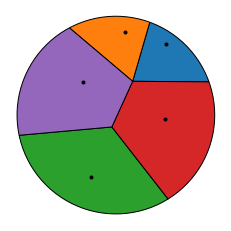

Final Areas:
[2.56866875 2.56866875 7.70600624 7.70600624 7.70600624]


In [3]:
def EqualAreasVoronoiMinPerim(init,poly,fact=100,areaC=None,nitLloyd=10,save_string=None):
    totarea = poly.area;
    
    ncells = len(init)
    
    meanarea = totarea/len(init) # target area for one cell
    meanareas = np.ones(len(init))/len(init)*totarea
    
    if(areaC is None):
        meanareas = np.ones(len(init))/len(init)*totarea
    else: 
        meanareas = areaC*totarea
    
    print(meanarea)
    coords = init
    
    for it in range(0,nitLloyd):
        ps, bnd, areas, vor, ridge_points = PolyVoronoi(coords,poly,fact=fact)
        for i in range(0,len(coords)):
            coords[i] = ps[i].centroid.coords
            
    xx,yy = poly.exterior.xy
    cc  = np.zeros((len(xx)-1,2))
    cc[:,0]=xx[0:-1]
    cc[:,1]=yy[0:-1]

                
    def myfunc(x, grad):
        vec = np.reshape(x,(-1,2))
        
        perims, gradP = PerimFuncGrad(vec,cc,plotting=0)
        gradt = np.zeros(vec.shape)
        val = np.sum(perims)
        
        for i in range(0,ncells):
            gradt = gradt+np.reshape(gradP[:,i],(-1,2))
        if grad.size > 0:
            grad[:] = gradt.flatten()
        if(np.min(perims)<-1):
            centroid = np.mean(np.reshape(x,(-1,2)),axis=0)
            centroids = np.zeros((len(x)/2,2))
            centroids[:,0] = centroid[0]
            centroids[:,1] = centroid[1]
            val = 10**3
            grad[:] = -0.1*(x-np.reshape(centroids,(-1,1)))
        return val
    def c(result, x, grad):
        vec = np.reshape(x,(-1,2))
        
        areas, gradA = AreaFuncGrad(vec,poly)
        result[:] = (areas-meanareas)
        if grad.size > 0:
            for i in range(0,len(init)):
                grad[i,:] = gradA[:,i]
    opt = nlopt.opt(nlopt.LD_MMA, 2*ncells)
    opt_interm = nlopt.opt(nlopt.LD_MMA, 2*ncells)
    opt_interm.set_xtol_rel(1e-8)
    opt_interm.set_ftol_rel(1e-8)
    opt.set_local_optimizer(opt_interm)
    #opt.set_lower_bounds(-3*np.ones(2*ncells))
    #opt.set_upper_bounds(3*np.ones(2*ncells))


    opt.set_min_objective(myfunc)
    tol = 1e-6*np.ones(len(init))
    print(tol)
    opt.add_inequality_mconstraint(c, tol)
    opt.set_xtol_rel(1e-6)
    opt.set_ftol_rel(1e-6)
    initialization = init.flatten()
    print(initialization)
    xres = opt.optimize(initialization)
    minf = opt.last_optimum_value()
    print("optimum at ", xres)
    print("minimum value = ", minf)
    print("result code = ", opt.last_optimize_result())        
        
        
        
    
    coords = np.reshape(xres,(-1,2))
    PolyVoronoi(coords,poly,plotting=1,fact=fact,save_string=save_string)
    print("Final Areas:")
    a, g = AreaFuncGrad(coords,poly)
    print(a)
    
    return coords


coords = 1.5*np.array([[-1,-1],[1,-1],[1,1],[-0.4,1.2],[0,0],[0.2,0.3],[-0.3,-0.2]])
coords = 1.5*np.array([[-1,-1],[1,-1],[1,1.3],[-1,1],[0,0],[0,-0.9],[0,1.4]])

#coords = np.array([[-2,0],[2,0],[0,-1],[0,0],[0,1]])

#coords = 2*np.array([[-1,-1],[1,-1],[1,1],[-1,1],[-1,0],[1,0],[0,1],[0,-1],[0,0]])

#coords = coords
outer_poly = np.array([[-3,-3],[3,-3],
                       [3,3],
                       [-3,3]]
                       )

thetas = np.linspace(0,2*np.pi,100)

xx = 3*np.cos(thetas)
yy = 3*np.sin(thetas)



c = np.zeros((len(xx),2))
c[:,0] = xx
c[:,1] = yy

outer_poly= c

oPcircle = Polygon(outer_poly)




case = 1

try:
    if(case==1):
        coords = random_points_within(oP, 5)
        areaC = np.array([0.1,0.1,0.3,0.3,0.3])
        areaC = areaC/np.sum(areaC)
        res = EqualAreasVoronoiMinPerim(coords,oPcircle,nitLloyd=10,areaC=areaC,save_string="VorDisk5_non_equal")
    if(case==2):
        coords = random_points_within(oP, 6)
        res = EqualAreasVoronoiMinPerim(coords,oP,nitLloyd=10,areaC=None,save_string="VorDisk6equal")
    if(case==3):
        coords = random_points_within(oP, 10)
        res = EqualAreasVoronoiMinPerim(coords,oP,nitLloyd=10,areaC=None,save_string="VorDisk10equal")

except:
    print("Nlopt failed!")


0.28867513459481287
[1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06]
[ 0.30033612  0.20247393 -0.60223681 -0.25425081 -0.04294126 -0.25144159
 -0.27252541  0.26067519  0.57909065 -0.27830403  0.01456069  0.74895758]
optimum at  [ 0.30038089  0.20938818 -0.59283466 -0.24811295 -0.03542283 -0.24746958
 -0.26528152  0.27085328  0.57741818 -0.27481326  0.01600533  0.75416166]
minimum value =  12.942274551082946
result code =  4


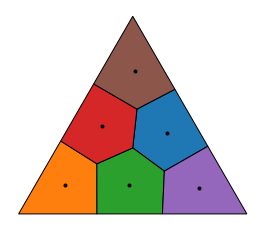

Final Areas:
[0.28867513 0.28867513 0.28867513 0.28867513 0.28867513 0.28867513]


In [4]:
# Equilateral triangle
outer_poly = np.array([[-1,-0.5],[1,-0.5],
                       [0,np.sqrt(3)-0.5]]
                       )

oP = Polygon(outer_poly)
coords = random_points_within(oP, 6)

areaC = np.array([0.1,0.1,0.3,0.3,0.3])
areaC = areaC/np.sum(areaC)



try:
    res = EqualAreasVoronoiMinPerim(coords,oP,nitLloyd=10,areaC=None,save_string="Equi10equal")
except:
    print("Nlopt failed!")

0.17320508075688773


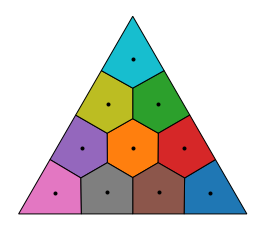

Final Areas:
0.1732050805954508   0.17320508137508886


In [5]:
# Equal areas alone




def EqualAreasVoronoiV2(init,poly,nit=10,debug=0,eps=1e-2,fact=100,areaC=None,nitLloyd=20,save_string=None):
    totarea = poly.area;
    meanarea = totarea/len(init) # target area for one cell
    meanareas = np.ones(len(init))/len(init)*totarea
    
    if(areaC is None):
        meanareas = np.ones(len(init))/len(init)*totarea
    else: 
        meanareas = areaC*totarea
    
    print(meanarea)
    coords = init
    for it in range(0,nitLloyd):
        ps, bnd, areas, vor, ridge_points = PolyVoronoi(coords,poly,debug=debug,fact=fact)
        for i in range(0,len(coords)):
            coords[i] = ps[i].centroid.coords
    # use scipy minimize
        
    def ObjFunc(x,p=1.1):
        x = np.reshape(x,(-1,2))
        areas, gradA = AreaFuncGrad(x,poly)
        gradt = np.zeros(x.shape)
        #part = np.sum(np.abs(areas-meanarea)**p)**(1/p-1)
        for i in range(0,len(x)):
            gradt = gradt+2*(areas[i]-meanareas[i])*np.reshape(gradA[:,i],(-1,2))
        return (np.sum((areas-meanareas)**2)), np.reshape(gradt,(-1,1))
    
    def GradFunc(x):
        x = np.reshape(x,(-1,2))
        areas, gradA = AreaFuncGrad(x,poly)
        gradt = np.zeros(x.shape)
        for i in range(0,len(x)):
            gradt = gradt+2*(areas[i]-meanarea)*np.reshape(gradA[:,i],(-1,2))
        return np.reshape(gradt,(-1,1))
    
    init = np.reshape(coords,(-1,1))
    res = minimize(ObjFunc,init,method='L-BFGS-B',jac=True,tol=1e-12)
    
    coords = np.reshape(res.x,(-1,2))
    PolyVoronoi(coords,poly,plotting=1,fact=fact,save_string=save_string)
    print("Final Areas:")
    a, g = AreaFuncGrad(coords,poly)
    print(np.min(a)," ",np.max(a))
    #print("Final obj: ",val)
    return coords
    
#oP = np.array([[-1,-0.5],
#               [1, -0.5],
#               [0,np.sqrt(3)-0.5]])

#oP = oP*4

oP = Polygon(oP)
    
coords = random_points_within(oP,10)     
case = 1
if(case==1):
    EqualAreasVoronoiV2(coords,oP,nit=21,nitLloyd=100,save_string="EqualAreas100")
if(case==2):
    coords = random_points_within(oP,10)     
    EqualAreasVoronoiV2(coords,oPcircle,nit=21,nitLloyd=100,save_string="EqualAreasDisk10")
if(case==3):
    coords = 0.5* random_points_within(oP,100)     
    EqualAreasVoronoiV2(coords,oPcircle,nit=21,nitLloyd=100,save_string="EqualAreasDisk100")
if(case==4):
    # Equilateral triangle
    outer_poly = np.array([[-1,-0.5],[1,-0.5],
                       [0,np.sqrt(3)-0.5]]
                       )

    oPequi = Polygon(outer_poly)
    coords = random_points_within(oPequi, 120)
    EqualAreasVoronoiV2(coords,oPequi,nitLloyd=1000,save_string="EqualAreasEqui120")

7.063839051749871


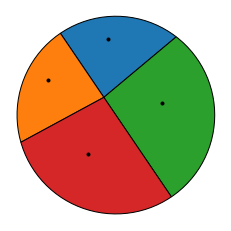

Final Areas:
4.709225919598701   9.418452091522717
[[-0.22463578  2.31704465]
 [-2.0702735   1.06445425]
 [ 1.41040536  0.36135378]
 [-0.85667421 -1.17724527]]
current value:  42.29552723190688
7.063839051749871


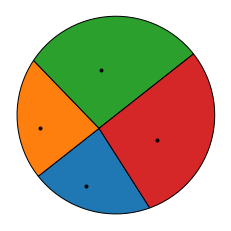

Final Areas:
4.709226019373074   9.418452071981307
[[-0.91451318 -2.14078014]
 [-2.29522612 -0.38881031]
 [-0.46072504  1.38110218]
 [ 1.23517794 -0.77076304]]
current value:  42.296090388038145
7.063839051749871


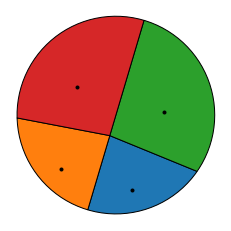

Final Areas:
4.709225923685115   9.418452090770236
[[ 0.48732288 -2.27627541]
 [-1.65078347 -1.64129442]
 [ 1.45367123  0.08257481]
 [-1.17294145  0.86266819]]
current value:  42.29584292208955
7.063839051749871


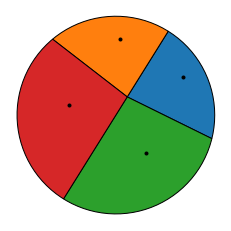

Final Areas:
4.709225990822289   9.418452077612848
[[ 2.02839208  1.14230998]
 [ 0.13643053  2.32392552]
 [ 0.90075107 -1.14384712]
 [-1.42308256  0.30750906]]
current value:  42.29581742461788
7.063839051749871


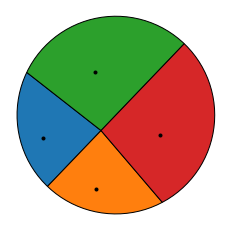

Final Areas:
4.7092258934894655   9.41845209655077
[[-2.21902663 -0.70351841]
 [-0.60872953 -2.24688039]
 [-0.64791553  1.30386865]
 [ 1.33020382 -0.59198231]]
current value:  42.295847389254504
7.063839051749871


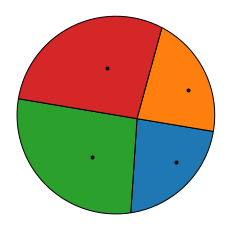

Final Areas:
4.7092259646235775   9.418452082698401
[[ 1.83053724 -1.43804085]
 [ 2.19976103  0.76154875]
 [-0.7129942  -1.2695307 ]
 [-0.25944802  1.43275825]]
current value:  42.295538544785074
7.063839051749871


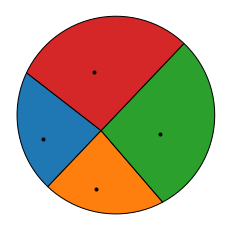

Final Areas:
4.7092259209148715   9.41845209134368
[[-2.2160417  -0.71280524]
 [-0.59935921 -2.24937383]
 [ 1.33268097 -0.58644511]
 [-0.65337727  1.30117893]]
current value:  42.29604927880811
7.063839051749871


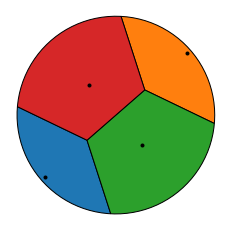

Final Areas:
4.709226034427504   9.418452069358397
[[-2.14531088 -1.8695898 ]
 [ 2.1452575   1.86959364]
 [ 0.80137399 -0.91948308]
 [-0.80134477  0.91950146]]
current value:  42.252258892538904
7.063839051749871


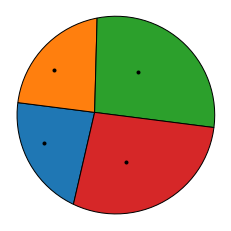

Final Areas:
4.709226031005906   9.418452069718006
[[-2.16773563 -0.84831302]
 [-1.8862422   1.36412245]
 [ 0.66201735  1.29691327]
 [ 0.31614652 -1.42136746]]
current value:  42.29619533371422
7.063839051749871


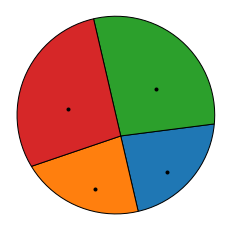

Final Areas:
4.709225910854021   9.418452093208094
[[ 1.54801221 -1.7386227 ]
 [-0.6248846  -2.24245403]
 [ 1.22317377  0.78973168]
 [-1.44589649  0.17083624]]
current value:  42.29556831351094
7.063839051749871


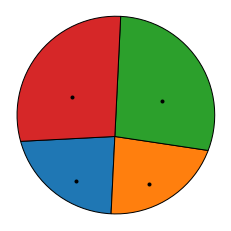

Final Areas:
4.709226030358802   9.418452069845898
[[-1.21302607 -1.98677778]
 [ 1.01461961 -2.09506458]
 [ 1.39241877  0.42593077]
 [-1.34454399  0.55895528]]
current value:  42.29609331723725
7.063839051749871


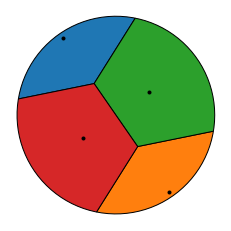

Final Areas:
4.709226034418722   9.418452069293997
[[-1.61846187  2.34053887]
 [ 1.61842114 -2.34059924]
 [ 1.00320379  0.69372462]
 [-1.00319764 -0.69369111]]
current value:  42.25221084195261
7.063839051749871


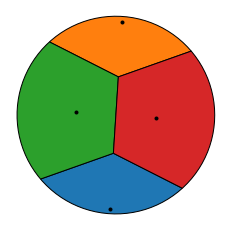

Final Areas:
4.709226034446292   9.418452069113004
[[-0.18415588 -2.83967426]
 [ 0.18419922  2.83965389]
 [-1.21713175  0.07896081]
 [ 1.21712393 -0.07894447]]
current value:  42.252181442109716
7.063839051749871


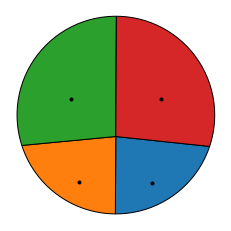

Final Areas:
4.709225897612323   9.418452095700648
[[ 1.10476065 -2.0490441 ]
 [-1.12573314 -2.03760123]
 [-1.36740351  0.5000384 ]
 [ 1.37245807  0.48600063]]
current value:  42.29559831975162
7.063839051749871


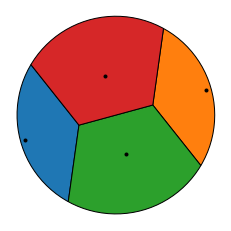

Final Areas:
4.709226034444456   9.418452069371154
[[-2.74551379 -0.74808477]
 [ 2.74555339  0.74812584]
 [ 0.32059894 -1.17679652]
 [-0.32064164  1.17678452]]
current value:  42.25233779166277
7.063839051749871


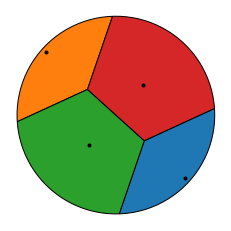

Final Areas:
4.709226034498643   9.418452069030902
[[ 2.1112002  -1.9079304 ]
 [-2.11123369  1.90803705]
 [-0.81774618 -0.9049709 ]
 [ 0.81779602  0.90488771]]
current value:  42.25216127780379
7.063839051749871


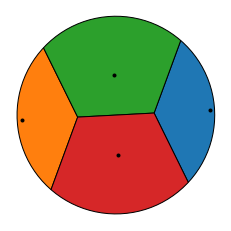

Final Areas:
4.709226034472583   9.418452069301104
[[ 2.84166044  0.15096657]
 [-2.8415873  -0.15100274]
 [-0.06479367  1.21797175]
 [ 0.06472872 -1.21796603]]
current value:  42.25254584347801
7.063839051749871


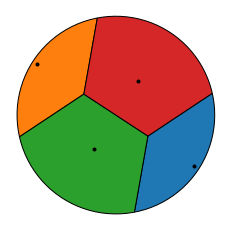

Final Areas:
4.709226034486477   9.418452069209517
[[ 2.38033844 -1.55945194]
 [-2.38028396  1.55935971]
 [-0.66837251 -1.02024618]
 [ 0.66830891  1.02030716]]
current value:  42.25280917693755
7.063839051749871


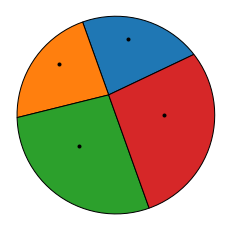

Final Areas:
4.709225898989573   9.418452095414626
[[ 0.36233005  2.29952744]
 [-1.73802752  1.54866478]
 [-1.12401878 -0.92542436]
 [ 1.4559552  -0.00307748]]
current value:  42.295563150123684
7.063839051749871


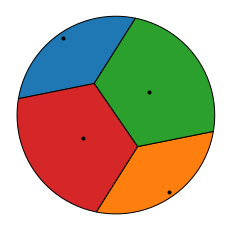

Final Areas:
4.709226034344454   9.418452069073663
[[-1.61292251  2.34437758]
 [ 1.61288198 -2.34440031]
 [ 1.00485199  0.69131659]
 [-1.00484176 -0.6913142 ]]
current value:  42.2521605219207


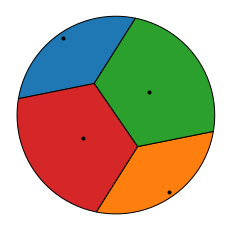

Best value:  42.2521605219207


In [6]:
def AreaPerimVoronoi(coords,poly):
    coords = np.reshape(coords,(-1,2))
    ps, bnd, areas, vor, ridge_pts = PolyVoronoi(coords,poly,debug=0,fact=10)
    perims = np.zeros(len(ps))
    for i in range(0,len(ps)):
        if ps[i].is_empty == 0:
            x,y = ps[i].exterior.xy
            perims[i] = np.sum(np.sqrt((x-np.roll(x,1))**2+(y-np.roll(y,1))**2))
            
    return areas, perims

def InitProposal(poly,ncells,ntries=10,areaC=None):
    poly = Polygon(poly)
    best = 10**16
    for i in range(0,ntries):
        coords = random_points_within(poly,ncells) 
        totarea = Polygon(poly).area
        meanarea = totarea/ncells
        res = EqualAreasVoronoiV2(coords,poly,nit=100,eps=1e-1,areaC=areaC)
        epst = 0
        print(res)
        areas, perims = AreaPerimVoronoi(res,poly)
        val = np.sum(perims)
        print("current value: ",val)

        if val<best:
            Candidate = res
            best = val
    PolyVoronoi(Candidate,poly,plotting=1,fact=100)
    print("Best value: ",best)
    return Candidate
    
outer_poly = np.array([[0,0],[1,0],
                       [1,1],
                       [0,1]]
                       )    
case=2
if case==1:
    Candidate = InitProposal(oP,3,ntries=10) 
if case==2:
    thetas = np.linspace(0,2*np.pi,100)

    xx = 3*np.cos(thetas)
    yy = 3*np.sin(thetas)



    c = np.zeros((len(xx),2))
    c[:,0] = xx
    c[:,1] = yy

    outer_poly= c

    oPcircle = Polygon(outer_poly)
    areaC = np.array([0.1,0.1,0.2,0.2])
    areaC = areaC/np.sum(areaC)
    Candidate = InitProposal(oPcircle,4,ntries=20,areaC=areaC) 


0.011436188079745314
0.011438215549508383
0.011434156479326402
Analytic gradient:  -0.02019222679870472
Finite diff:        -0.02019222915129737
0.011436188079745314
0.0057195269273788586
0.002853499619877561
0.0013007269690431902
0.0011086309385469938
0.0013169863347087588
0.0008490280338762465
0.0004733349602213524
0.0005376657126265295
0.00032479756120901984
0.0003925610727101639
0.00030450905525847424
0.0002862931528260594
0.00026360808627618176
0.00030739929716854365
0.00024299034911158
0.00021391368849266187
0.00024220079248428954
0.00017923263805060856
0.00014904490517153945
7.117036697036388e-05
4.184931197521277e-05
3.372153652444437e-05
5.402853911160805e-05
4.674937220706397e-05
2.29740146894533e-05
2.790109560997453e-05
4.4822784550580574e-05
8.265132371244623e-05
4.319819354722465e-05
9.566006484008931e-05
3.13149339029313e-05
4.145586234690347e-05
4.402469367535445e-05
0.00012752898860352393
0.0001278345937354297
9.994400936752396e-05
5.2924109066750535e-05
6.618352496082

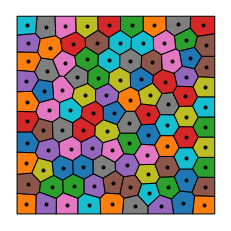

Final Areas:
[0.04604203 0.04330199 0.0399431  0.04522105 0.04008301 0.03895491
 0.04284199 0.03979573 0.0397455  0.04278262 0.03968059 0.04608958
 0.04040121 0.03983669 0.03796717 0.04063888 0.04000014 0.04211706
 0.04258843 0.04038793 0.03995195 0.04096976 0.03899184 0.04109142
 0.03994847 0.03728364 0.03607004 0.04092035 0.0417011  0.04056923
 0.04072301 0.03849785 0.03952786 0.04086247 0.04298311 0.0443916
 0.04080715 0.04018281 0.03882513 0.03429899 0.03922913 0.0414977
 0.03770114 0.03974895 0.03921396 0.03722423 0.04367824 0.0401723
 0.03638917 0.04030806 0.03955778 0.03837687 0.03904474 0.03942965
 0.03911563 0.04057246 0.04084613 0.03624193 0.03932254 0.04188633
 0.03369332 0.03990069 0.03982307 0.04223558 0.03888385 0.03614425
 0.04014887 0.0392475  0.03961578 0.0411866  0.04150886 0.04557551
 0.04149182 0.03948059 0.03836153 0.03662972 0.0379545  0.0380776
 0.0401109  0.04090589 0.03605071 0.04046105 0.04039832 0.04348825
 0.043097   0.03836881 0.04108696 0.04018928 0.041140

array([[ 0.68249246, -0.88997867],
       [ 0.13771975,  0.15720043],
       [ 0.9017376 , -0.12207148],
       [ 0.87957798,  0.90727214],
       [-0.88835885,  0.72713665],
       [ 0.89748605, -0.72874078],
       [-0.54168949,  0.25856777],
       [ 0.52196766,  0.10760753],
       [ 0.70986105, -0.01455387],
       [-0.46023195,  0.04711686],
       [ 0.25212059,  0.36424293],
       [-0.66838609,  0.68225453],
       [-0.64508655, -0.7273019 ],
       [-0.23039418,  0.01755312],
       [ 0.45707305, -0.92201867],
       [ 0.36659434,  0.53386843],
       [-0.5199849 ,  0.52539425],
       [-0.7003925 ,  0.45010257],
       [-0.09232436, -0.16496027],
       [-0.06915925,  0.55248833],
       [-0.33281204, -0.52534057],
       [-0.89101182,  0.54345543],
       [-0.18121218,  0.38017516],
       [-0.06842188,  0.90944136],
       [-0.24230718, -0.33267118],
       [ 0.91146248,  0.48453968],
       [-0.03600533, -0.35641213],
       [-0.70999592,  0.89278999],
       [-0.29702976,

In [7]:
# LloydGradient

def LloydGrad(init,poly,debug=0,eps=1e-2,fact=100):
    
    ncells = len(init)
    
    #for it in range(0,nitLloyd):
    #    ps, bnd, areas, vor, ridge_points = PolyVoronoi(coords,poly,debug=debug,fact=fact)
    #    for i in range(0,len(coords)):
    #        coords[i] = ps[i].centroid.coords
    # use scipy minimize
        
    def ObjFunc(x):
        coords = np.reshape(x,(-1,2))      
        
        ps, bnd, areas, vor, ridge_points = PolyVoronoi(coords,poly,debug=debug,fact=fact,plotting=0)
        
        gradt = np.zeros(coords.shape)

        areas = np.zeros(ncells)
        moments = np.zeros(ncells)
        
        centroids = np.zeros((ncells,2))
        
        for i in range(0,ncells):
            centroids[i,:] = ps[i].centroid.coords
            
            x,y = ps[i].exterior.xy
            
            L   = np.zeros(len(x)-1)
            eta = np.zeros(len(x)-1)
            xi  = np.zeros(len(x)-1)
            xip = np.zeros(len(x)-1)
                        
            #plt.figure()
            
            #plt.plot(x,y,'o')
            for j in range(0,len(x)-1):
                pt2 = np.array([x[j+1],y[j+1]])
                pt1 = np.array([x[j],y[j]])
                
                L[j] = np.linalg.norm(pt1-pt2)
                
                mid = 0.5*(pt1+pt2)
                ptplot = np.zeros((2,2))
                ptplot[0,:] = mid+0.9*(pt1-mid)
                ptplot[1,:] = mid+0.9*(pt2-mid)
                
                #plt.plot(ptplot[0,0],ptplot[0,1],'rx')
                #plt.plot(ptplot[1,0],ptplot[1,1],'bx')
                
                tvec = pt1-pt2
                tvec = tvec/np.linalg.norm(tvec)
                nvec = np.array([tvec[1],-tvec[0]])
                nvec = nvec/np.linalg.norm(nvec)   # outer normal
                
                eta[j] = np.dot(pt1-coords[i,:],nvec)  # normal distances
                
                xip[j]  = np.dot(pt1-coords[i,:],tvec)
                xi[j]   = np.dot(pt2-coords[i,:],tvec)
                
                
                #print(centroids)
                #print(np.dot(nvec,mid-centroids[i,:]))
                
            areas[i] = 0.5*np.dot(eta,L)
            moments[i] = 0.25*np.dot(eta**3,L)+1/12*np.dot(eta,xip**3-xi**3)
            
            #print(areas[i]," ",moments[i])
            #print("AREA: ",ps[i].area)
            
            #plt.axis("scaled")
            #plt.show()
          
        
        val = np.sum(moments)
        
        
        #part = np.sum(np.abs(areas-meanarea)**p)**(1/p-1)
        for i in range(0,ncells):
            gradt[i,:] = 2*areas[i]*(coords[i,:]-centroids[i,:])
        gradt = gradt.flatten()
        print(np.max(gradt))
        return val, gradt
    
    
    
    
    
    init = init.flatten()
    d    = np.random.rand(len(init))
    epst = 1e-4
    
   
    
    val,grad = ObjFunc(init)
    v1,unused = ObjFunc(init+epst*d)
    v2,unused = ObjFunc(init-epst*d)
    
    print("Analytic gradient: ",np.dot(grad,d))
    print("Finite diff:       ",(v1-v2)/2/epst)
    
    
    
    
    res = minimize(ObjFunc,init,method='L-BFGS-B',jac=True)
    print(res)
    coords = np.reshape(res.x,(-1,2))
    PolyVoronoi(coords,poly,plotting=1,fact=fact)
    print("Final Areas:")
    a, g = AreaFuncGrad(coords,poly)
    print(a)
    #print("Final obj: ",val)
    return coords
    
#oP = np.array([[-1,-0.5],
#               [1, -0.5],
#               [0,np.sqrt(3)-0.5]])

#oP = oP*4
outer_poly = np.array([[-1,-1],[1,-1],
                       [1,1],
                       [-1,1]]
                       )    

oP = Polygon(outer_poly)
  
coords = random_points_within(oP, 100)    
    
    
LloydGrad(coords,oP)

[1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06]
[-2.27625946  0.43286731 -1.6690487   2.10359344  2.2773776   1.50267893
 -0.65257298 -2.15580483  2.32301497 -1.36758326  0.70484214  0.21224509
  0.54142852  2.16374716 -0.8853322  -0.31903206  0.98817022 -2.06028351
 -2.26564058 -1.87751057]
optimum at  [-2.10337823  0.4191339  -1.88239804  2.23513827  2.19867964  1.9384855
 -0.63261813 -1.86130888  2.29619528 -1.16926446  1.29434806  0.45608299
  0.19927731  2.14277201 -0.36849926  0.17926171  1.0744888  -2.13164163
 -2.23213357 -1.83015301]
minimum value =  23.447154591053184
result code =  3


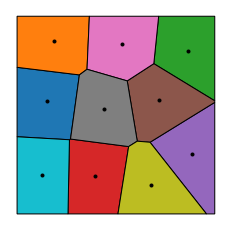

Final Areas:
[3.59999993 3.60000018 3.60000001 3.59999992 3.6        3.60000015
 3.60000023 3.5999999  3.59999965 3.60000003]


In [8]:
def LloydOptim(init,poly,fact=100,areaC=None,nitLloyd=10,save_string=None):
    totarea = poly.area;
    
    ncells = len(init)
    
    meanarea = totarea/len(init) # target area for one cell
    meanareas = np.ones(len(init))/len(init)*totarea
    
    if(areaC is None):
        meanareas = np.ones(len(init))/len(init)*totarea
    else: 
        meanareas = areaC*totarea
    coords = init
    for it in range(0,nitLloyd):
        ps, bnd, areas, vor, ridge_points = PolyVoronoi(coords,poly,fact=fact)
        for i in range(0,len(coords)):
            coords[i] = ps[i].centroid.coords
            
    xx,yy = poly.exterior.xy
    cc  = np.zeros((len(xx)-1,2))
    cc[:,0]=xx[0:-1]
    cc[:,1]=yy[0:-1]
    
    grad = np.zeros(2*ncells)
    
    def ObjFunc(x):
        coords = np.reshape(x,(-1,2))      
        
        ps, bnd, areas, vor, ridge_points = PolyVoronoi(coords,poly,plotting=0)
        
        gradt = np.zeros(coords.shape)

        areas = np.zeros(ncells)
        moments = np.zeros(ncells)
        
        centroids = np.zeros((ncells,2))
        
        for i in range(0,ncells):
            centroids[i,:] = ps[i].centroid.coords
            
            x,y = ps[i].exterior.xy
            
            L   = np.zeros(len(x)-1)
            eta = np.zeros(len(x)-1)
            xi  = np.zeros(len(x)-1)
            xip = np.zeros(len(x)-1)
                        
            #plt.figure()
            
            #plt.plot(x,y,'o')
            for j in range(0,len(x)-1):
                pt2 = np.array([x[j+1],y[j+1]])
                pt1 = np.array([x[j],y[j]])
                
                L[j] = np.linalg.norm(pt1-pt2)
                
                mid = 0.5*(pt1+pt2)
                ptplot = np.zeros((2,2))
                ptplot[0,:] = mid+0.9*(pt1-mid)
                ptplot[1,:] = mid+0.9*(pt2-mid)
                
                #plt.plot(ptplot[0,0],ptplot[0,1],'rx')
                #plt.plot(ptplot[1,0],ptplot[1,1],'bx')
                
                tvec = pt1-pt2
                tvec = tvec/np.linalg.norm(tvec)
                nvec = np.array([tvec[1],-tvec[0]])
                nvec = nvec/np.linalg.norm(nvec)   # outer normal
                
                eta[j] = np.dot(pt1-coords[i,:],nvec)  # normal distances
                
                xip[j]  = np.dot(pt1-coords[i,:],tvec)
                xi[j]   = np.dot(pt2-coords[i,:],tvec)
                
                
                #print(centroids)
                #print(np.dot(nvec,mid-centroids[i,:]))
                
            areas[i] = 0.5*np.dot(eta,L)
            moments[i] = 0.25*np.dot(eta**3,L)+1/12*np.dot(eta,xip**3-xi**3)
            
            #print(areas[i]," ",moments[i])
            #print("AREA: ",ps[i].area)
            
            #plt.axis("scaled")
            #plt.show()
          
        
        val = np.sum(moments)
        
        
        #part = np.sum(np.abs(areas-meanarea)**p)**(1/p-1)
        for i in range(0,ncells):
            gradt[i,:] = 2*areas[i]*(coords[i,:]-centroids[i,:])
        gradt = gradt.flatten() 
        #print("Max grad: ",np.max(gradt))
        return val, gradt

                
    def myfunc(x, grad):
        funcL, gradL = ObjFunc(x)
        val = funcL
        if grad.size > 0:
            grad[:] = np.array(gradL)
        return val
    
    def c(result, x, grad):
        vec = np.reshape(x,(-1,2))
        
        areas, gradA = AreaFuncGrad(vec,poly)
        result[:] = (areas-meanareas)
        if grad.size > 0:
            for i in range(0,len(init)):
                grad[i,:] = gradA[:,i]
    opt = nlopt.opt(nlopt.LD_AUGLAG, 2*ncells)
    opt_interm = nlopt.opt(nlopt.LD_MMA, 2*ncells)
    opt_interm.set_xtol_rel(1e-6)
    opt_interm.set_ftol_rel(1e-6)
    #opt.set_local_optimizer(opt_interm)
    #opt.set_lower_bounds(np.min(outer_poly)*np.ones(2*ncells))
    #opt.set_upper_bounds(np.max(outer_poly)*np.ones(2*ncells))


    opt.set_min_objective(myfunc)
    tol = 1e-6*np.ones(len(init))
    print(tol)
    opt.add_inequality_mconstraint(c, tol)
    opt.set_xtol_rel(1e-6)
    opt.set_ftol_rel(1e-6)
    initialization = init.flatten()
    print(initialization)
    xres = opt.optimize(initialization)
    minf = opt.last_optimum_value()
    print("optimum at ", xres)
    print("minimum value = ", minf)
    print("result code = ", opt.last_optimize_result())        
        
        
        
    
    coords = np.reshape(xres,(-1,2))
    PolyVoronoi(coords,poly,plotting=1,fact=fact,save_string=save_string)
    print("Final Areas:")
    a, g = AreaFuncGrad(coords,poly)
    print(a)
    
    return coords


coords = 1.5*np.array([[-1,-1],[1,-1],[1,1],[-0.4,1.2],[0,0],[0.2,0.3],[-0.3,-0.2]])
coords = 1.5*np.array([[-1,-1],[1,-1],[1,1.3],[-1,1],[0,0],[0,-0.9],[0,1.4]])

#coords = np.array([[-2,0],[2,0],[0,-1],[0,0],[0,1]])

#coords = 2*np.array([[-1,-1],[1,-1],[1,1],[-1,1],[-1,0],[1,0],[0,1],[0,-1],[0,0]])

#coords = coords


case = 1

if (case==1):
    outer_poly = np.array([[-3,-3],[3,-3],
                       [3,3],
                       [-3,3]]
                       )
    oP = Polygon(outer_poly)
    coords = random_points_within(oP, 10)
    res = LloydOptim(coords,oP,nitLloyd=10,save_string="LloydEqualAreasSquare10")
if(case==2):
    coords = random_points_within(oPcircle, 10)
    areaC = np.array([0.1,0.1,0.4,0.4,0.4])
    res = LloydOptim(coords,oPcircle,nitLloyd=0,save_string="LloydEqualAreasDisk10")
if(case==3):
    ncells = 21
    coords = random_points_within(oPequi, ncells)
    areaC = np.array([0.1,0.1,0.4,0.4,0.4])
    res = LloydOptim(coords,oPequi,nitLloyd=0,save_string="LloydEqualAreasEqui"+str(ncells))

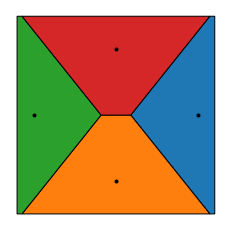

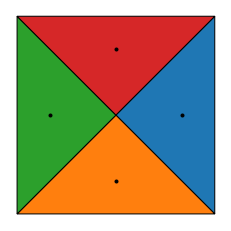

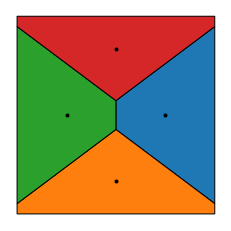

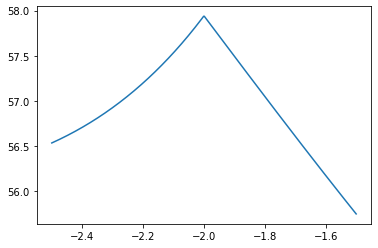

In [9]:
coords = 2*np.array([[-1,-1],[1,-1],[1,1],[-1,1]])

#coords = coords
outer_poly = np.array([[-3,-3],[3,-3],
                       [3,3],
                       [-3,3]]
                       )


N = 500
ts = np.linspace(-2.5,-1.5,N)
vs = np.zeros(N)
for i in range(0,len(ts)):
    t = ts[i]
    coords = np.array([[-t,0],[0,-2],[t,0],[0,2]])
    if (i==0):
        perims = PerimVoronoi(coords,outer_poly,plotting=1,save_string="perim_non_smooth_start")
    elif i==(N/2):
        perims = PerimVoronoi(coords,outer_poly,plotting=1,save_string="perim_non_smooth_mid")
    elif i==len(ts)-1: 
        perims = PerimVoronoi(coords,outer_poly,plotting=1,save_string="perim_non_smooth_end")
    else:
        perims = PerimVoronoi(coords,outer_poly,plotting=0)
    
    vs[i] = np.sum(perims)
    
plt.figure()
plt.plot(ts,vs)
plt.savefig("perim_non_smooth_graph.pdf")
plt.show()

7.063839051749871
[1.e-06 1.e-06 1.e-06 1.e-06]
[-1.78921144 -0.58708939  1.68124679  0.69341904  0.55078764 -1.65212023
 -0.66379921  1.62940931]
optimum at  [-2.59985794 -1.13699852  2.58967735  1.20331578  0.47754745 -1.15299433
 -0.47380456  1.10977853]
minimum value =  42.24464787690345
result code =  3


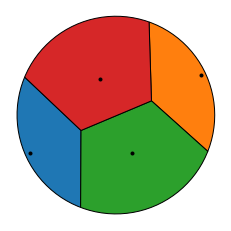

Final Areas:
[4.7092245  4.70923473 9.41844851 9.41844846]
current value:  42.24464787690345
[0]
7.063839051749871
[1.e-06 1.e-06 1.e-06 1.e-06]
[-1.51847138 -0.99624459  1.05529316 -1.35447202 -1.05138774  1.47579252
  1.42138522  1.1968093 ]
optimum at  [-1.46647857 -1.84223775  0.90767056 -2.18827608 -1.3295521   0.64595654
  1.46655271  0.27952608]
minimum value =  42.3066995715959
result code =  4


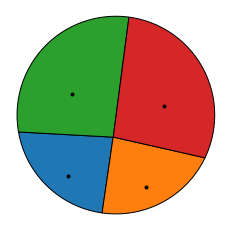

Final Areas:
[4.70922603 4.70922603 9.41845207 9.41845207]
current value:  42.3066995715959
[0 1]
7.063839051749871
[1.e-06 1.e-06 1.e-06 1.e-06]
[ 1.37757721  1.20493406  1.18742487 -1.32793793 -1.16183455  1.34055272
 -1.35869062 -1.2038951 ]
optimum at  [ 2.08863334  1.0487988   1.98373828 -1.26991087 -0.38914963  1.4382422
 -0.57003428 -1.39685807]
minimum value =  42.28915085203819
result code =  4


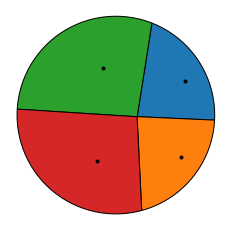

Final Areas:
[4.70922603 4.70922603 9.41845207 9.41845207]
current value:  42.28915085203819
[0 2 1]
7.063839051749871
[1.e-06 1.e-06 1.e-06 1.e-06]
[ 0.60070841 -1.68556678  1.6049671   0.70330123 -0.72534179  1.72709462
 -1.69299645 -0.57448714]
optimum at  [ 1.42925215 -1.75928051  2.20963959  0.3025477   0.13795735  1.39313476
 -0.91751264 -1.10790372]
minimum value =  42.28362856335134
result code =  3


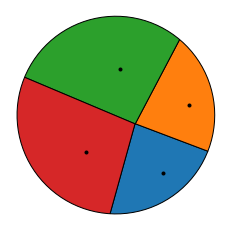

Final Areas:
[4.70922603 4.70922603 9.41845207 9.41845207]
current value:  42.28362856335134
[0 3 1 2]
7.063839051749871
[1.e-06 1.e-06 1.e-06 1.e-06]
[ 1.46156036 -1.07607649 -1.09723496 -1.36685287  1.06011173  1.43137232
 -1.44177438  1.16395441]
optimum at  [ 1.39566726 -1.88686639 -0.93640119 -2.15427162  1.34505093  0.6261156
 -1.45279767  0.31114806]
minimum value =  42.301036085746134
result code =  4


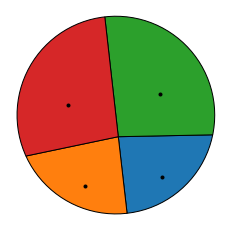

Final Areas:
[4.70922603 4.70922603 9.41845207 9.41845207]
current value:  42.301036085746134
[0 1 2 4 3]
7.063839051749871
[1.e-06 1.e-06 1.e-06 1.e-06]
[-1.43800185  1.11319354  1.10886236  1.37590267  1.43656016 -1.1504565
 -1.08237385 -1.40713941]
optimum at  [-1.3703512   1.90501521  0.95097784  2.14131378  1.44928153 -0.32314128
 -1.35383201 -0.61914097]
minimum value =  42.29711764987088
result code =  4


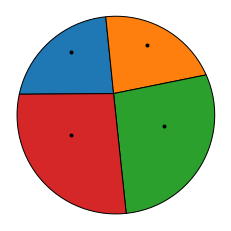

Final Areas:
[4.70922603 4.70922603 9.41845207 9.41845207]
current value:  42.29711764987088
[0 1 2 5 3 4]
7.063839051749871
[1.e-06 1.e-06 1.e-06 1.e-06]
[-0.60467972 -1.68029441  1.71730357 -0.65918189  0.65159758  1.64258074
 -1.69507224  0.63119706]
optimum at  [-0.22241355 -2.21104102  1.7651914  -1.40212788  1.08625673  0.95304668
 -1.40221626 -0.15816311]
minimum value =  42.27940700636562
result code =  4


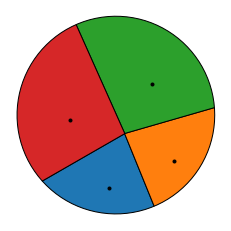

Final Areas:
[4.70922603 4.70922603 9.41845207 9.41845207]
current value:  42.27940700636562
[0 6 1 2 3 4 5]
7.063839051749871
[1.e-06 1.e-06 1.e-06 1.e-06]
[-0.30887765  1.80422159 -1.81800442 -0.19561608  0.20639678 -1.75168668
  1.74984314  0.31855962]
optimum at  [-0.99482286  1.95834794 -2.14801085  0.38120459 -0.44912755 -1.34315502
  1.18068137  0.81090432]
minimum value =  42.27084237318107
result code =  4


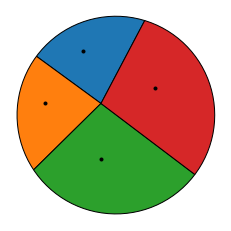

Final Areas:
[4.70922603 4.70922603 9.41845207 9.41845207]
current value:  42.27084237318107
[0 7 1 2 3 4 5 6]
7.063839051749871
[1.e-06 1.e-06 1.e-06 1.e-06]
[ 0.81687478 -1.62828228 -0.9436269   1.52895796 -1.58780585 -0.91361579
  1.54052756  0.8327199 ]
optimum at  [ 1.47273864 -2.43051933 -1.52481164  2.42318727 -1.06213846 -0.66579988
  1.09611011  0.66792911]
minimum value =  42.19261572838004
result code =  3


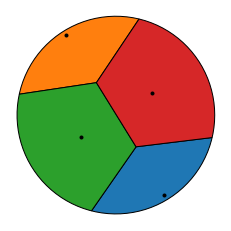

Final Areas:
[4.70922603 4.70922603 9.41845207 9.41845207]
current value:  42.19261572838004
[8 0 1 2 3 4 5 6 7]
7.063839051749871
[1.e-06 1.e-06 1.e-06 1.e-06]
[-0.39140654 -1.73007934  1.81453342 -0.55362439 -1.69992428  0.48910366
  0.61154601  1.65567217]
optimum at  [ 0.04245374 -2.20447277  1.83025138 -1.24160264 -1.39823033 -0.26275307
  0.98054881  1.04078845]
minimum value =  42.27284209140566
result code =  4


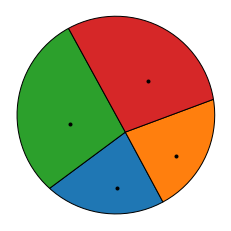

Final Areas:
[4.70922603 4.70922603 9.41845207 9.41845207]
current value:  42.27284209140566
[0 1 2 9 3 4 5 6 7 8]
[42.19261572838004, 42.24464787690345, 42.27084237318107, 42.27284209140566, 42.27940700636562, 42.28362856335134, 42.28915085203819, 42.29711764987088, 42.301036085746134, 42.3066995715959]


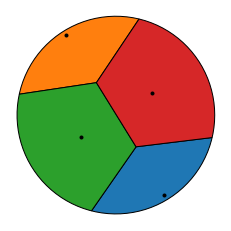

Best value:  42.19261572838004


In [10]:
def InitProposalPerim(poly,ncells,ntries=10,areaC=None):
    poly = Polygon(poly)
    best = 10**16
    vals = []
    Candidates = []
    Candidate = random_points_within(poly,ncells) 
    for i in range(0,ntries):
        coords = random_points_within(poly,ncells) 
        totarea = Polygon(poly).area
        meanarea = totarea/ncells
        try:
            res = EqualAreasVoronoiMinPerim(coords,poly,nitLloyd=5,areaC=areaC)
        except:
            print("Nlopt failed!")  
        epst = 0
        areas, perims = AreaPerimVoronoi(res,poly)
        val = np.sum(perims)
        print("current value: ",val)

        vals.append(val)
        Candidates.append(res)
        ind = np.argsort(vals)
        print(ind)
        vals[:] = [vals[j] for j in ind]
        Candidates[:] = [Candidates[j] for j in ind]
    print(vals)
    Candidate = Candidates[0]
    best = vals[0]
    PolyVoronoi(Candidate,poly,plotting=1,fact=100)
    print("Best value: ",best)
    return Candidate
    
outer_poly = np.array([[0,0],[1,0],
                       [1,1],
                       [0,1]]
                       )    

areaC = np.array([0.1,0.1,0.2,0.2])
areaC = areaC/np.sum(areaC)
Candidate = InitProposalPerim(oPcircle,4,ntries=10,areaC=areaC) 